In [1]:
# Importing data manipulation and visualization libraries
import pandas as pd  # Pandas for handling structured data (DataFrames)
import numpy as np  # NumPy for numerical computations
import matplotlib.pyplot as plt  # Matplotlib for data visualization
import matplotlib.dates as mdates #  Matplotlib utility for formatting and managing date-based x-axes

from sklearn.preprocessing import MinMaxScaler # Importing a scaler for feature normalization
from sklearn.metrics import mean_absolute_error # Importing mean_absolute_error metric

# Importing TensorFlow/Keras for building and training deep learning models
from tensorflow.keras.models import Sequential  # Sequential API for building models
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training
from tensorflow.keras import layers  # Keras layers for model architecture
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  
# EarlyStopping prevents overfitting by stopping training when performance degrades
# ReduceLROnPlateau decreases learning rate if the model stops improving

Load Data

In [2]:
df_prices = pd.read_csv('AAPL_historic_prices.csv') # Load CSV with market prices
df_prices.head()

,Date,Open,High,Low,Close,Volume
0,12-12-1980,0.128348,0.128906,0.128348,0.128348,469033600
1,15-12-1980,0.122210,0.122210,0.121652,0.121652,175884800
2,16-12-1980,0.113281,0.113281,0.112723,0.112723,105728000
3,17-12-1980,0.115513,0.116071,0.115513,0.115513,86441600
4,18-12-1980,0.118862,0.119420,0.118862,0.118862,73449600


In [3]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%d-%m-%Y') # Convert to datetime

Keep dates the are equal to the article size so we can compare the prediciton results.
(Skip this step if not interested to compare the two results)

In [4]:
df_prices = df_prices.where(df_prices['Date'] >= '01-01-2023').dropna() # Filter dates
df_prices.head()

,Date,Open,High,Low,Close,Volume
10603,2023-01-03,130.279999,130.899994,124.169998,125.070000,112117500.0
10604,2023-01-04,126.889999,128.660004,125.080002,126.360001,89113600.0
10605,2023-01-05,127.129997,127.769997,124.760002,125.019997,80962700.0
10606,2023-01-06,126.010002,130.289993,124.889999,129.619995,87754700.0
10607,2023-01-09,130.470001,133.410004,129.889999,130.149994,70790800.0


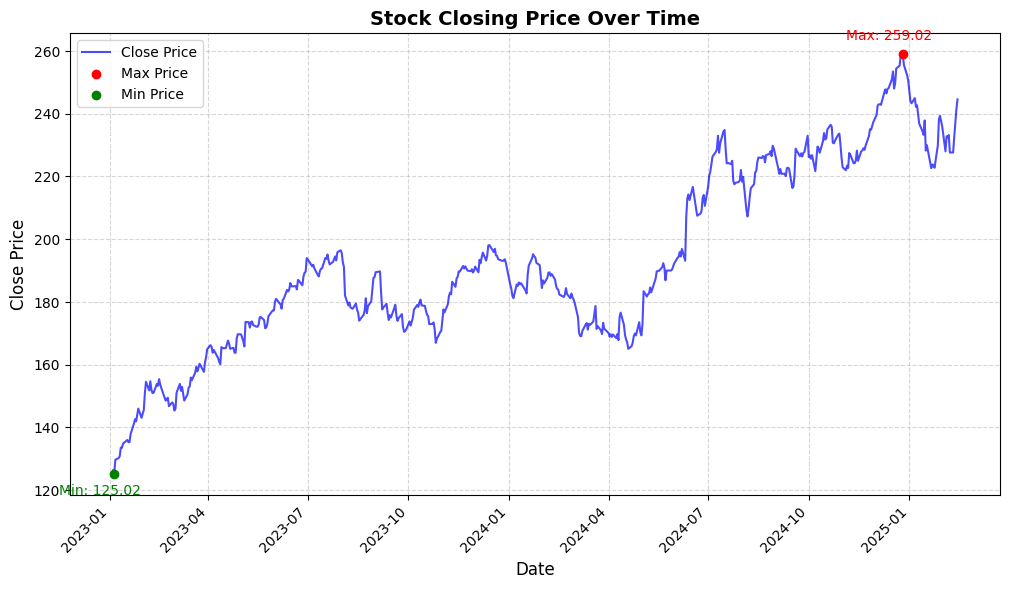

In [5]:
plt.figure(figsize=(12, 6))  # Set figure size for better visibility

# Plot closing prices over time
plt.plot(df_prices['Date'], df_prices['Close'], linestyle='-', color='b', alpha=0.7, label="Close Price")

# Add title and labels
plt.title("Stock Closing Price Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Highlight the maximum and minimum closing prices
plt.scatter(df_prices['Date'][df_prices['Close'].idxmax()], df_prices['Close'].max(), 
            color='red', label="Max Price", zorder=3)
plt.scatter(df_prices['Date'][df_prices['Close'].idxmin()], df_prices['Close'].min(), 
            color='green', label="Min Price", zorder=3)

# Add annotations for max and min prices
plt.annotate(f"Max: {df_prices['Close'].max():.2f}", 
            (df_prices['Date'][df_prices['Close'].idxmax()], df_prices['Close'].max()), 
            textcoords="offset points", xytext=(-10,10), ha='center', fontsize=10, color='red')

plt.annotate(f"Min: {df_prices['Close'].min():.2f}", 
            (df_prices['Date'][df_prices['Close'].idxmin()], df_prices['Close'].min()), 
            textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=10, color='green')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [6]:
df_prices = df_prices[['Date', 'Close']]
df_prices.set_index('Date', inplace=True)
df_prices

,Close
Date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-09,130.149994
...,...
2025-02-10,227.649994
2025-02-11,232.619995
2025-02-12,236.869995


Feature Engineering

In [7]:
# Scale data between 0 and 1

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_prices)

scaled_data.shape

(532, 1)

In [8]:
# Convert the data to a format suitable for LSTM (X, y)
def create_dataset(data, time_step):
    X, y = [], []
    # Iterate over the dataset while maintaining the lookback window
    for i in range(len(data) - time_step - 1):
        # Select 'time_step' number of past values as input features (X)
        X.append(data[i:(i + time_step)])
        # Select the next value as the target output (y)
        y.append(data[i + time_step, 0])  
    # Convert lists to NumPy arrays for model training
    return np.array(X), np.array(y)

time_step = 60  # Look-back window for LSTM (uses the past 60 time steps)
X, y = create_dataset(scaled_data, time_step)  # Prepare training data

In [9]:
X.shape, y.shape

((471, 60, 1), (471,))

In [10]:
# Reshape y for future predections, it expects a 2D array

y = y.reshape((y.shape[0],  1))

y.shape

(471, 1)

In [11]:
# Create train, val, test splits

q_80 = int(len(X) * 0.8)
q90 = int(len(X) * 0.9)

X_train, y_train = X[:q_80], y[:q_80]
X_val, y_val = X[q_80:q90], y[q_80:q90]
X_test, y_test = X[q90:], y[q90:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((376, 60, 1), (376, 1), (47, 60, 1), (47, 1), (48, 60, 1), (48, 1))

In [12]:
model = Sequential([
                    # Input layer: Defines the input shape based on the training data
                    layers.Input((X_train.shape[1], 1)),  # Input shape is (number of features, 1), where X_train.shape[1] is the number of features
                    # First LSTM layer: This layer will learn sequential patterns from the input data
                    layers.LSTM(128, return_sequences=True),  # 128 units and return sequences for the next LSTM layer
                    # Dropout layer: Helps prevent overfitting by randomly setting a fraction of input units to zero during training
                    layers.Dropout(0.2),  # Dropout rate of 20%
                    layers.LSTM(64),
                    layers.Dropout(0.2),
                    #Fully connected (Dense) layer with 64 neurons and ReLU activation
                    layers.Dense(64, activation='relu'),  # ReLU activation function to introduce non-linearity
                    layers.Dense(64, activation='relu'),
                    # Output layer: Predicts a single value (regression task)
                    layers.Dense(1)  # Output layer with a single unit for regression
])

# Display the model architecture summary
model.summary()  # Prints a summary of the model including layers, output shapes, and parameters

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,353 (485.75 KB)

 Trainable params: 124,353 (485.75 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    loss='huber',  # Use Huber loss, which is less sensitive to outliers than MSE
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['mean_absolute_error']  # Track MAE (Mean Absolute Error) as an evaluation metric
) #'mse', 'mae'

In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss to determine stopping
        patience=15,  # Stop training if no improvement for 15 epochs (increased patience)
        restore_best_weights=True,  # Restore the model weights from the epoch with the best validation loss
        mode='min'  # Stop when 'val_loss' stops decreasing (lower is better)
    ),
    ReduceLROnPlateau(  # Reduce learning rate when validation loss plateaus
        monitor='val_loss',  # Monitor validation loss
        factor=0.2,  # Reduce learning rate by a factor of 0.2 when triggered
        patience=5,  # Wait 5 epochs before reducing the learning rate if no improvement
        min_lr=0.00001  # Set a lower bound for the learning rate to prevent it from getting too small
    )
]

In [15]:
history = model.fit(
    X_train,  # Training data (features)
    y_train,  # Training data (labels)
    validation_data=(X_val, y_val),  # Validation data to monitor performance during training
    epochs=50,  # Number of training epochs (iterations over the entire dataset)
    batch_size=16,  # Number of samples per gradient update (mini-batch size)
    verbose=1,  # Display progress logs during training (1 = progress bar)
    callbacks=callbacks  # List of callbacks (EarlyStopping and ReduceLROnPlateau) to control training behavior
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0465 - mean_absolute_error: 0.2434 - val_loss: 0.0016 - val_mean_absolute_error: 0.0485 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - mean_absolute_error: 0.0637 - val_loss: 0.0119 - val_mean_absolute_error: 0.1505 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0021 - mean_absolute_error: 0.0489 - val_loss: 0.0038 - val_mean_absolute_error: 0.0795 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0023 - mean_absolute_error: 0.0523 - val_loss: 0.0050 - val_mean_absolute_error: 0.0930 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - mean_absolute_error: 0.0406 - val_loss: 0.0029 - val_mean_absolute_error: 0.0682 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018 - mean_absolute_error: 0.0453 - val_loss: 0.0014 - val_mean_absolute_

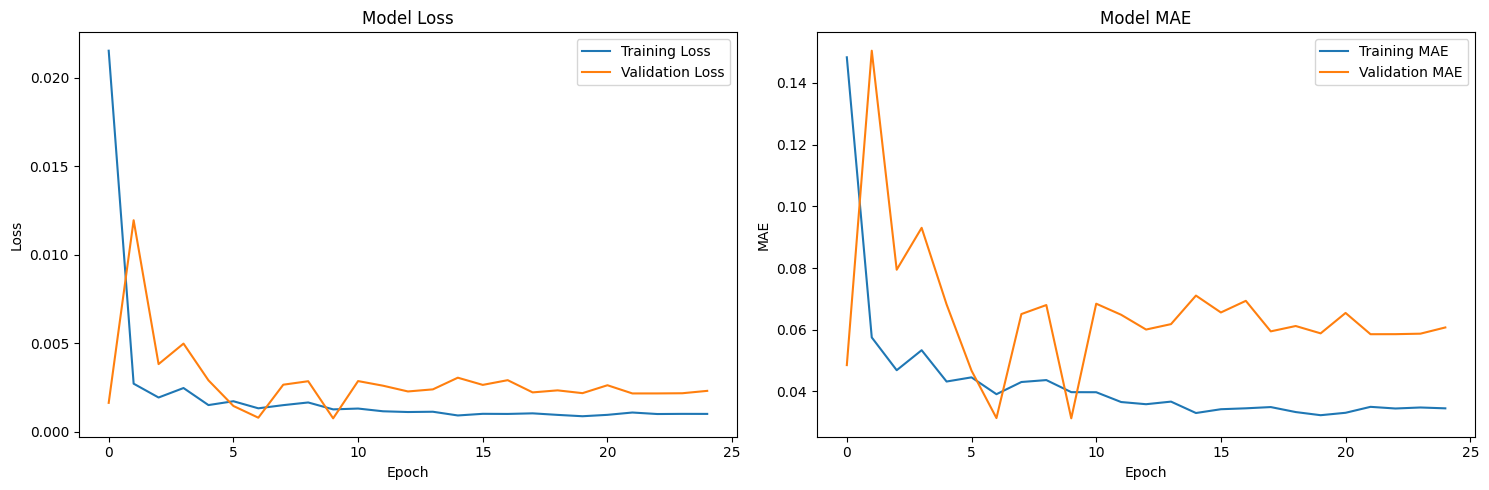

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
    
plt.tight_layout()
plt.show()

Evaluation

In [17]:
# Evaluate the model on the test data (X_test and y_test) without printing the verbose output
test_loss, test_mae = model.evaluate(
    X_test,  # Test features
    y_test,  # True labels for the test data
    verbose=0  # Set verbose to 0 to suppress the output during evaluation
)

# Print the test loss and test Mean Absolute Error (MAE) with 4 decimal precision
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

Test Loss: 0.0017, Test MAE: 0.0519


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


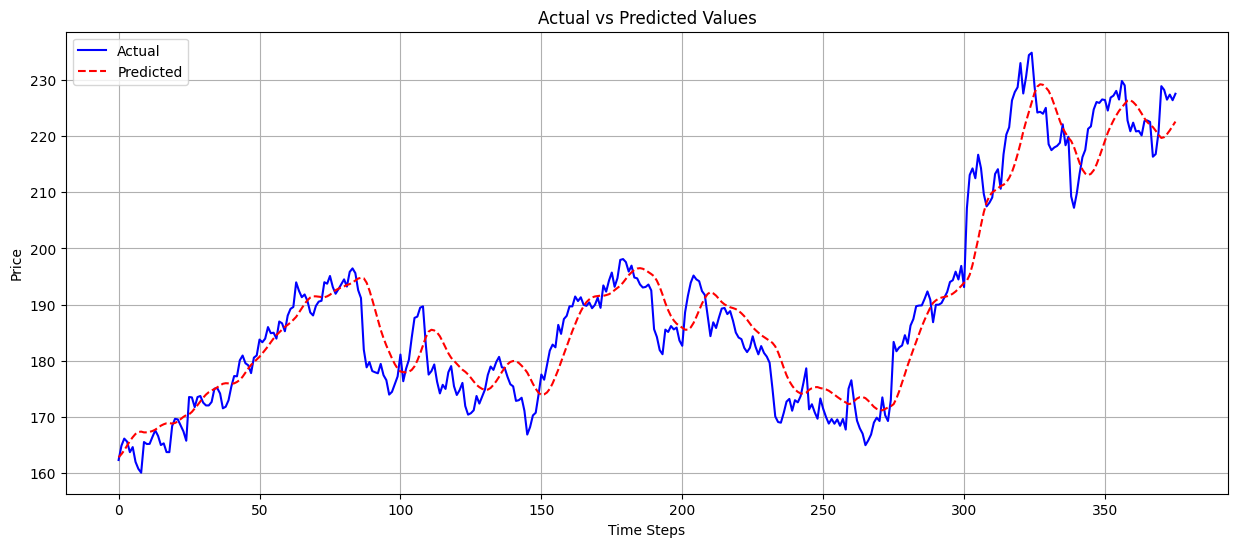

MSE: 29.15
RMSE: 5.40
MAE: 4.24


In [18]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_train)
predictions_unscaled = scaler.inverse_transform(predictions)
y_train_unscaled = scaler.inverse_transform(y_train)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_train_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_train_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_train_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Validation Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


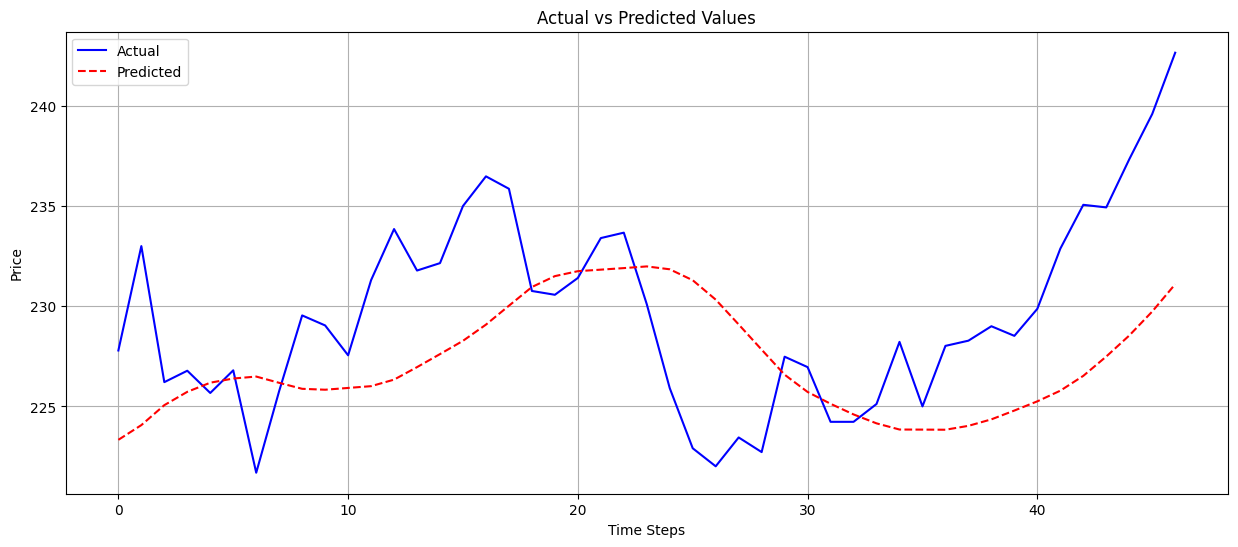

MSE: 26.82
RMSE: 5.18
MAE: 4.19


In [19]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_val)
predictions_unscaled = scaler.inverse_transform(predictions)
y_val_unscaled = scaler.inverse_transform(y_val)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_val_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_val_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_val_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Test Data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


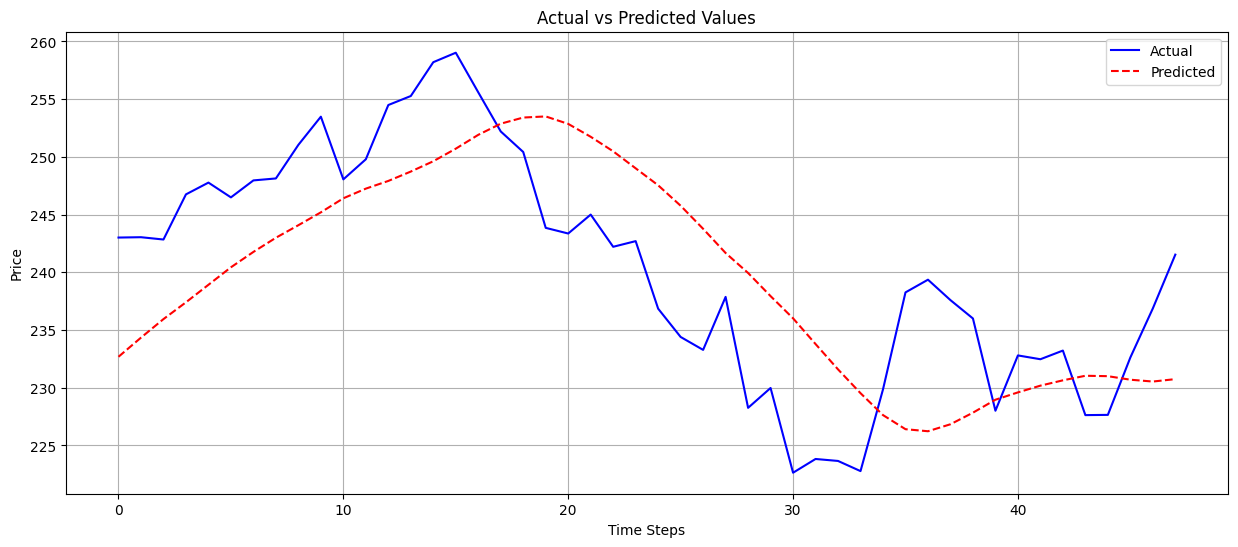

MSE: 59.83
RMSE: 7.73
MAE: 6.95


In [20]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_test)
predictions_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_test_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_test_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Generate and View Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


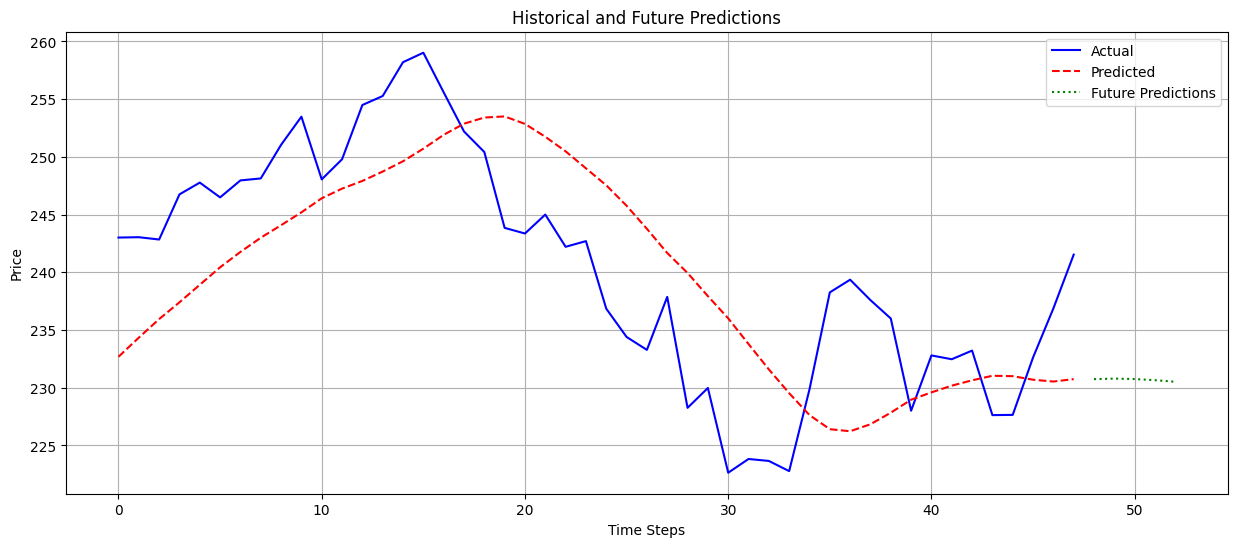


Predicted values for next 5 time steps:
Step 1: 230.75
Step 2: 230.79
Step 3: 230.75
Step 4: 230.66
Step 5: 230.52


In [21]:
# First generate predictions for test set
test_predictions = model.predict(X_test)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
y_test_unscaled = scaler.inverse_transform(y_test)

def predict_future_steps(model, last_sequence, n_steps=5, scaler=scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_reshape = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(current_reshape, verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Get the last sequence and predict future
last_sequence = X_test[-1]
future_preds = predict_future_steps(model, last_sequence, n_steps=5)

# Plot
plt.figure(figsize=(15, 6))

# Historical data
plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(test_predictions_unscaled, label='Predicted', color='red', linestyle='--')

# Future predictions
future_indices = np.arange(len(y_test_unscaled), len(y_test_unscaled) + 5)
plt.plot(future_indices, future_preds, label='Future Predictions', color='green', linestyle=':')

plt.title('Historical and Future Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print predictions
print("\nPredicted values for next 5 time steps:")
for i, pred in enumerate(future_preds, 1):
    print(f"Step {i}: {pred[0]:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


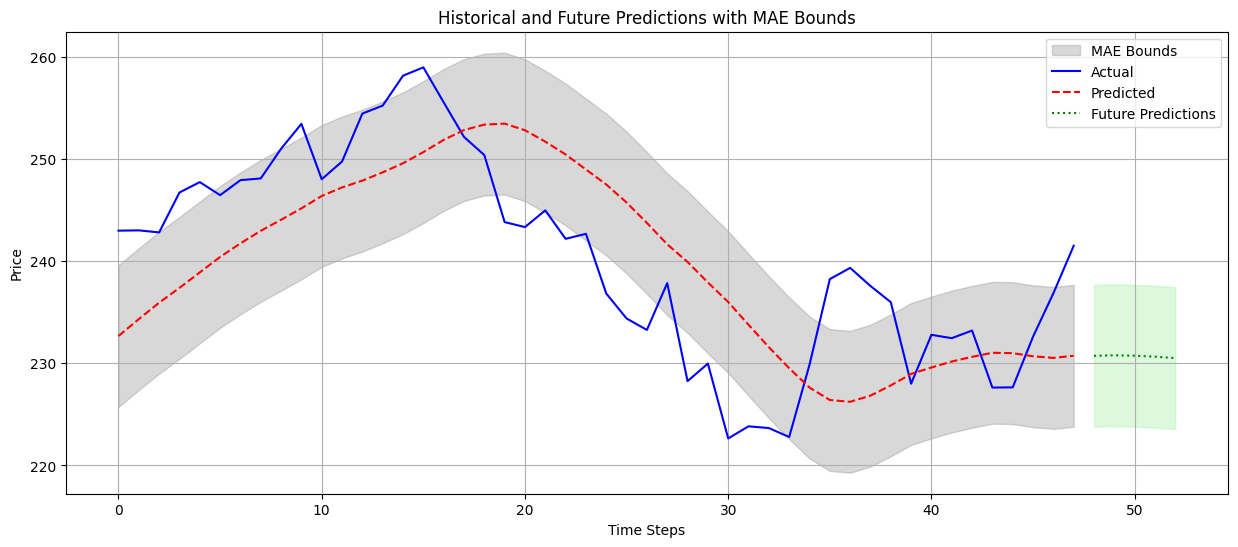


Mean Absolute Error (MAE): 6.95

Predicted values for next 5 time steps (with MAE bounds):

Step | Prediction | Lower Bound | Upper Bound
--------------------------------------------------
Step  1 |     230.75 |     223.79 |     237.70
Step  2 |     230.79 |     223.84 |     237.74
Step  3 |     230.75 |     223.80 |     237.71
Step  4 |     230.66 |     223.71 |     237.61
Step  5 |     230.52 |     223.57 |     237.47


In [22]:
# First generate predictions for test set
test_predictions = model.predict(X_test)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)
y_test_unscaled = scaler.inverse_transform(y_test)

# Calculate MAE using scaled values
mae = mean_absolute_error(y_test, test_predictions)
mae_unscaled = mean_absolute_error(y_test_unscaled, test_predictions_unscaled)

def predict_future_steps(model, last_sequence, n_steps=5, scaler=scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for n_steps in range(n_steps):
        current_reshape = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(current_reshape, verbose=0)
        future_predictions.append(next_pred[0, 0])

        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Get the last sequence and predict future
last_sequence = X_test[-1]
future_preds = predict_future_steps(model, last_sequence, n_steps=5)

# Plot
plt.figure(figsize=(15, 6))

# Historical data with MAE bounds
plt.fill_between(range(len(y_test_unscaled)), 
                test_predictions_unscaled.flatten() - mae_unscaled, 
                test_predictions_unscaled.flatten() + mae_unscaled, 
                alpha=0.3, color='gray', label='MAE Bounds')

plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(test_predictions_unscaled, label='Predicted', color='red', linestyle='--')

# Future predictions with MAE bounds
future_indices = np.arange(len(y_test_unscaled), len(y_test_unscaled) + 5)
plt.fill_between(future_indices, 
                future_preds.flatten() - mae_unscaled, 
                future_preds.flatten() + mae_unscaled, 
                alpha=0.3, color='lightgreen')

plt.plot(future_indices, future_preds, label='Future Predictions', color='green', linestyle=':')

plt.title('Historical and Future Predictions with MAE Bounds')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print predictions with MAE bounds
print(f"\nMean Absolute Error (MAE): {mae_unscaled:.2f}")
print("\nPredicted values for next 5 time steps (with MAE bounds):")
print("\nStep | Prediction | Lower Bound | Upper Bound")
print("-" * 50)
for i, pred in enumerate(future_preds, 1):
    lower_bound = pred[0] - mae_unscaled
    upper_bound = pred[0] + mae_unscaled
    print(f"Step {i:2d} | {pred[0]:10.2f} | {lower_bound:10.2f} | {upper_bound:10.2f}")